# Radial Line with Params

Params are
- img_ind (index of the image from image array)
- no_of_lines (no of radial lines)
- no_of_points_along_line (no of points along each radial line)

## Setup

In [1]:
import warnings
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

2023-02-20 22:14:48.715999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Disable warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#def function_that_warns():
#    warnings.warn("deprecated", DeprecationWarning)

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    function_that_warns()  # this will not show a warning

## Prepare DataSet

### Data

In [3]:
#data directory here!
data_dir = "dataset/data" 

In [4]:
images = [] #store the images here!
nr_of_images = 0 #just to count the number of images
for image_name in os.listdir(data_dir):
    image = plt.imread(os.path.join(data_dir, image_name))
    images.append(image)
    nr_of_images += 1

### Greysacle Copies of Data

In [5]:
if os.path.exists('dataset/grayscale_images') == False:
    os.makedirs('dataset/grayscale_images')
grayscale_images_dir = 'dataset/grayscale_images'

In [6]:
grayscale_images = [] #store the images here!
for image_name in os.listdir(data_dir):
    image = plt.imread(os.path.join(data_dir, image_name))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = Image.fromarray(gray_image)
    gray_image.save(os.path.join(grayscale_images_dir, image_name))
    gray_image = np.array(gray_image) #convert back to array
    grayscale_images.append(gray_image)

## Sequence count

In [7]:
def numOfSubseq(arr, n):
    i, inc_count, dec_count = 0, 0, 0
    max = [0]*n
    min = [0]*n
 
    # k2, k1 are used to store the count of max and min array
    k1 = 0
    k2 = 0
 
    # Comparison to store the index of first element of array
    if (arr[0] < arr[1]):
        min[k1] = 0
        k1 += 1
    else:
        max[k2] = 0
        k2 += 1
 
    # Comparison to store the index from second to second last index of array
    for i in range(1, n-1):
        if (arr[i] < arr[i - 1] and arr[i] < arr[i + 1]):
            min[k1] = i
            k1 += 1
 
        if (arr[i] > arr[i - 1] and arr[i] > arr[i + 1]):
            max[k2] = i
            k2 += 1
 
    # Comparison to store the index of last element of array
    if (arr[n - 1] < arr[n - 2]):
        min[k1] = n - 1
        k1 += 1
    else:
        max[k2] = n - 1
        k2 += 1
 
    # Count of number of maximal contiguous increasing and decreasing subsequences
    if (min[0] == 0):
        inc_count = k2
        dec_count = k1 - 1
    else:
        inc_count = k2 - 1
        dec_count = k1
 
    print("Increasing Subsequence Count: ", inc_count)
    print("Decreasing Subsequence Count: ", dec_count)
    print("Increasing and Decreasing Subsequence Count: ", inc_count + dec_count)

## Change along radial line

In [8]:
def funct_change_along_radial_line(img_ind, no_of_lines, no_of_points_along_line):
    
    plt.imshow(images[img_ind])
    plt.show()
    
    plt.imshow(grayscale_images[img_ind], cmap = 'gray')
    plt.show()
    
    model = tf.keras.models.load_model('PithDetector')
    
    image = images[img_ind]
    height, width = image.shape[0], image.shape[1]
    image = cv2.resize(image, (224,224))
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)[0]
    image = np.squeeze(image, axis = 0)
    image = cv2.resize(image, (width, height))
    #plt.imshow(image)
    #plt.plot(prediction[0]*width, prediction[1]*height, '.')
    #plt.show()
    
    gray_image = grayscale_images[img_ind]
    ret, thresh = cv2.threshold(gray_image, 1, 255, 1)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contoursImage = cv2.drawContours(gray_image, contours, -1, 255, 3)
    plt.imshow(contoursImage)
    plt.show()
    
    #contours_array
    contours_array = []
    for i in range(len(contours)):
        for j in range(len(contours[i])):
            contours_array.append(contours[i][j][0])
    
    random_nr_arr = np.random.randint(0, len(contours_array)-1, size = no_of_lines)
    line_arr = []
    pixel_values_arr = []
    
    for random_nr in random_nr_arr:
        random_point_on_contour = contours_array[random_nr]
        line = np.linspace(np.array([prediction[0]*width, prediction[1]*height]), random_point_on_contour, no_of_points_along_line)
    
        #we convert to integer numbers
        for i in range(len(line)):
            for j in range(2):
                line[i,j] = int(line[i,j])

        line = line.astype('int') #we do this for proper indexing

        pixel_values = []
        i = 1
        while i < len(line):
            value = gray_image[line[i][1]-1, line[i][0]-1] 
            pixel_values.append(value)
            i += 1
            
        line_arr.append(line)
        pixel_values_arr.append(pixel_values)
    
    
    plt.imshow(gray_image, cmap = 'gray')
    plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
    
    for random_nr in random_nr_arr:
        random_point_on_contour = contours_array[random_nr]
        plt.plot(random_point_on_contour[0], random_point_on_contour[1], '.', color = 'r', markersize = 10)
        plt.plot(np.array([random_point_on_contour[0], prediction[0]*width]), np.array([random_point_on_contour[1], prediction[1]*height]))
    plt.show()
    
    plt.imshow(gray_image)
    for line in line_arr:
        plt.plot(line[:,0], line[:,1], '.')
    plt.show()

    for pixel_values in pixel_values_arr:
        plt.plot(np.linspace(0,no_of_points_along_line-1,no_of_points_along_line-1), pixel_values)
    plt.xlabel('point from estimated pith location to contour')
    plt.ylabel('pixel value')
    plt.show()
    
    for pixel_values in pixel_values_arr:
        numOfSubseq(pixel_values,len(pixel_values))
    

## Run

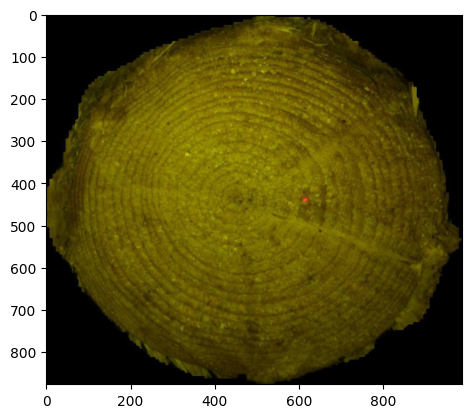

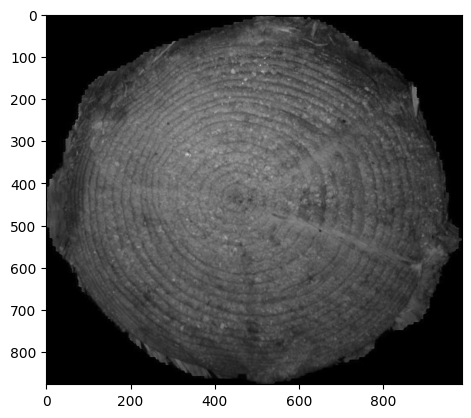

2023-02-20 22:14:57.572007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 1s/step


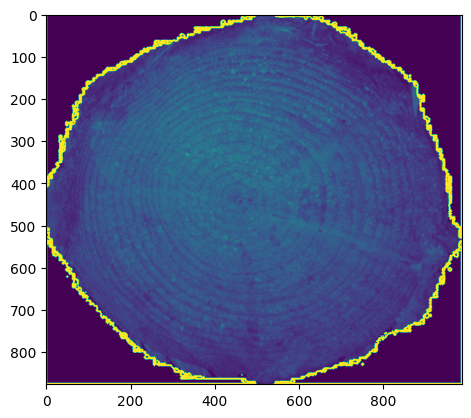

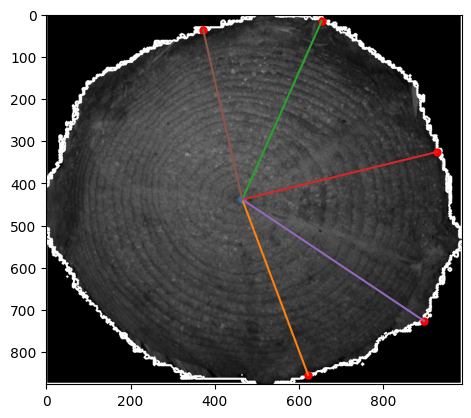

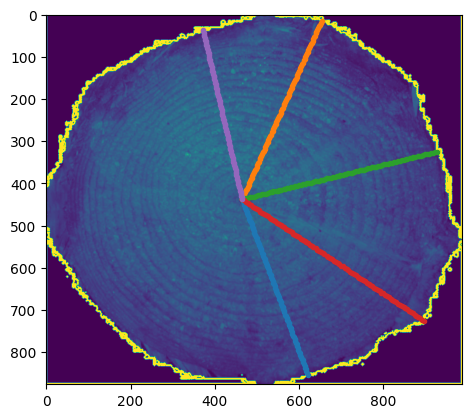

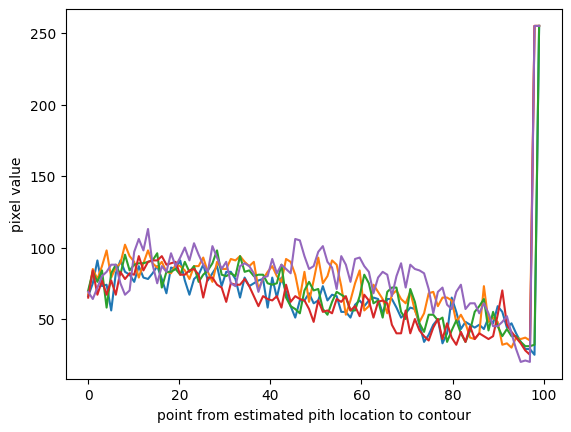

Increasing Subsequence Count:  27
Decreasing Subsequence Count:  28
Increasing and Decreasing Subsequence Count:  55
Increasing Subsequence Count:  28
Decreasing Subsequence Count:  27
Increasing and Decreasing Subsequence Count:  55
Increasing Subsequence Count:  25
Decreasing Subsequence Count:  25
Increasing and Decreasing Subsequence Count:  50
Increasing Subsequence Count:  31
Decreasing Subsequence Count:  28
Increasing and Decreasing Subsequence Count:  59
Increasing Subsequence Count:  24
Decreasing Subsequence Count:  25
Increasing and Decreasing Subsequence Count:  49


In [9]:
#rand_nr = np.random.randint(1, nr_of_images-1, size = 1)[0]
funct_change_along_radial_line(1,5,100)